In [45]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import random

In [46]:
def clear_variables():
    """Clears only user-defined variables while keeping functions, classes, and imports."""
    protected = {
        name for name, obj in globals().items()
        if name.startswith('__') or
           callable(obj) or
           isinstance(obj, type) or
           name in ['np', 'plt', 'heapq', 'random', 'clear_variables']  # Add your imports and this function itself
    }

    # Delete everything not in the protected set
    to_delete = [name for name in globals() if not name.startswith('_') and name not in protected]
    for name in to_delete:
        del globals()[name]
    
    # Delete them
    for name in to_delete:
        del globals()[name]

def oracle_select(ucb_values, k):
    """Selects top-k arms using UCB values."""
    return heapq.nlargest(k, range(len(ucb_values)), key=lambda i: ucb_values[i])

def expect_reward(mu,super_arm):
    product = 1
    for i in super_arm:
        # print(f"{i}th μ is {mu[i]}")
        # print()
        product *= (1-mu[i]) # must be mu_on
    return 1 - product

def trigger(super_arm,mu_on):
    mu_update = np.zeros(len(super_arm))# X_i,t
    observed_arm = []
    for i in super_arm:
        observed_arm.append(i)
        if random.random() < mu_on[i]: # X_i,t == 1
            mu_update[len(observed_arm) - 1] = 1
            return mu_update,observed_arm
    return mu_update,observed_arm # if 0, it is no arm searched out

In [47]:
def offline(m,mu_off,num_each_arm):
    delta = 0.1
    sample = np.zeros(m)
    log_CLCB = np.log(np.divide(2*m*num_each_arm ,delta))# n in paper: 一个臂拉取多少次，fix
    mu_hat_off = np.zeros(m)
    LCB = np.zeros(m)
    choose = [np.random.randint(10, num_each_arm + 1) for i in range(m)]
    for i in range(m):
        sample[i] = np.random.binomial(choose[i],mu_off[i])
        mu_hat_off[i] = np.divide(sample[i],num_each_arm)
        LCB[i] = mu_hat_off[i]- np.sqrt(np.divide(log_CLCB,2* num_each_arm))
        
    return choose,mu_hat_off, LCB

def RewardOff(m, mu_off, k, mu_on,num_each_arm,off_turn):
    N_off , mu_hat_off,LCB = offline(m, mu_off,num_each_arm)
    print(f"mu_hat_off:{mu_hat_off}")
    print(f"LCB:{LCB}")
    super_arm = oracle_select(LCB, k)
    print(f"super_arm_off:{super_arm}")
    reward = expect_reward(mu_on, super_arm)
    # print(f"reward:{reward}")
    return reward, N_off,mu_hat_off

In [48]:
def hybrid(m,k,t,N_online,mu_on,mu_hat_on,N,mu_hat_off,V):
    ucb_online = np.zeros(m)
    ucb_hybrid = np.zeros(m)
    
    for i in range(m):
        # Pure online UCB
        # log_term = np.log(4 * m * t)
        log_term = np.log(100)

        # N_online
        if N_online[i] == 0:
            ucb_online[i] = 1
        else:
            ucb_online[i] = mu_hat_on[i] + np.sqrt(2 * log_term / (N_online[i]))

        # N[i] + N_online[i] == 0
        if N[i] + N_online[i] == 0:
            ucb_hybrid[i] = 1
        else:
            ucb_hybrid[i] = np.divide(N[i]*mu_hat_off[i] + N_online[i]* mu_hat_on[i], N[i] + N_online[i]) + np.sqrt(2 * log_term / (N_online[i]+N[i])) + np.divide(N[i]*V[i],N[i] + N_online[i])
            
    # ucb = np.minimum(ucb_online, ucb_hybrid)
    ucb = np.minimum(np.minimum(ucb_online, ucb_hybrid), np.ones(m))
    print(f"ucb={ucb}")

    ## Trigger part
    # super_arm = oracle_select(ucb,k)
    super_arm = oracle_select(ucb,k)
    print(f"hybrid super_arm:{super_arm}")

    reward_online = expect_reward(mu_on,super_arm)

    mu_update, observed_arm = trigger(super_arm,mu_on)


    # Reward part
    for i in observed_arm: 
        N_online[i] += 1

    if mu_update.sum() != 0:
        for idx, arm in enumerate(observed_arm):
            if idx == len(observed_arm) - 1: # chosen one
                mu_hat_on[arm] += np.divide(1 - mu_hat_on[arm],N_online[arm])
                continue
            mu_hat_on[arm] += np.divide(0 - mu_hat_on[arm],N_online[arm]) # triggered but not chosen

    else:
        for arm in observed_arm: # all did not chosen by observed
            mu_hat_on[arm] += np.divide(0 - mu_hat_on[arm],N_online[arm])
    return reward_online,N_online,mu_hat_on



In [ ]:
def single_run_hybrid(m, k, T, reward_star, mu_on,gap_offline, N, mu_hat_off, V1):
    import os
    from scipy.interpolate import make_interp_spline
    from scipy.signal import savgol_filter

    # 1.initial
    N_online,mu_hat_on = np.zeros(m),np.zeros(m)
    N_biased,mu_hat_biased  = np.zeros(m),np.zeros(m)
    gap_online = np.zeros(T)
    gap_hybrid_biased = np.zeros(T)
    cumulative_online = 0.0
    cumulative_hybrid = 0.0

    # 2. running 
    for t in range(1, T+1):
        print("--------------------------------------------------")
        save_path = r"C:\Users\Pluviophile\Desktop\graph\5.15\N is upperbound of random\V=0.2,N=200,[0.4,0.6]\V"
        os.makedirs(save_path, exist_ok=True)
        print(f"t={t}")
        print("online part:")
        reward_online,N_online,mu_hat_on= hybrid(m,k,t,N_online,mu_on,mu_hat_on,N = np.zeros(m),mu_hat_off=np.zeros(m),V = np.zeros(m))
        cumulative_online += (reward_star - reward_online)
        print(f"gap_on:{reward_star - reward_online}")
        gap_online[t - 1] = cumulative_online
        
        print("##########################--------------------------")
        print("biased part:")
        reward_bias,N_biased,mu_hat_biased= hybrid(m,k,t,N_biased,mu_on,mu_hat_biased,N,mu_hat_off,V1)
        print(f"reward_bias:{reward_bias}")
        cumulative_hybrid += (reward_star - reward_bias)
        gap_hybrid_biased[t - 1] = cumulative_hybrid
        print(f"gap_hybrid:{reward_star - reward_bias}")

        # Plot every 200 steps
        if t % 200 == 0:
            plt.figure()
            plt.plot(gap_offline, color='green', label='CLCB')
            plt.plot(gap_online, color='blue', label='CUCB')
            plt.plot(gap_hybrid_biased, color='crimson', label='H-CUCB')

            plt.xlim(1, t - 1)
            plt.ylim(0, 50)
            plt.xlabel("Time Steps (t)")
            plt.ylabel("Cumulative Regret")
            plt.title(f"V={V1[0]}, N={N[0]}")
            plt.legend(loc='upper left', frameon=True, shadow=True)
            plt.grid(True, linestyle='--', alpha=0.7)

            file_name = f"graph_t{t}.pdf"  # Save as PDF
            plt.savefig(os.path.join(save_path, file_name), format='pdf')
            plt.close()
            # plt.figure()
            # x = np.arange(1, t + 1)

            # x_smooth = np.linspace(1, t , 5000)

            # def smooth_data(y, window=31):
            #     window = min(len(y) // 2 * 2 + 1, window)  # ensure odd and <= len(y)
            #     return savgol_filter(y, window_length=window, polyorder=3)

            # y_off = smooth_data(gap_offline[:t])
            # y_on = smooth_data(gap_online[:t])
            # y_hb = smooth_data(gap_hybrid_biased[:t])

            # # --- Now apply cubic spline interpolation ---
            # smooth_gap_offline = make_interp_spline(x, y_off, k=3)(x_smooth)
            # smooth_gap_online = make_interp_spline(x, y_on, k=3)(x_smooth)
            # smooth_gap_hybrid = make_interp_spline(x, y_hb, k=3)(x_smooth)

            # # --- Plot ---
            # plt.plot(x_smooth, smooth_gap_offline, color='green', label='CLCB')
            # plt.plot(x_smooth, smooth_gap_online, color='blue', label='CUCB')
            # plt.plot(x_smooth, smooth_gap_hybrid, color='crimson', label='H-CUCB')

            # plt.xlim(1, t)
            # plt.ylim(0, 300)
            # plt.xlabel("Time Steps (t)")
            # plt.ylabel("Cumulative Regret")
            # plt.title(f"V={V1[0]}, N={30}")
            # plt.legend(loc='upper left', frameon=True, shadow=True)
            # plt.grid(True, linestyle='--', alpha=0.7)

            # file_name = f"graph_t{t}.pdf"
            # plt.savefig(os.path.join(save_path, file_name), format='pdf')
            # plt.close()
    return gap_online , gap_hybrid_biased

Clear up
mu_on:[0.3        0.32222222 0.34444444 0.36666667 0.38888889 0.41111111
 0.43333333 0.45555556 0.47777778 0.5       ]
super_arm_oracle:[9, 8, 7, 6, 5]
reward_star:0.952560516689529
mu_hat_off:[0.    0.46  0.355 0.035 0.025 0.015 0.075 0.45  0.115 0.085]
LCB:[-0.16276236  0.29723764  0.19223764 -0.12776236 -0.13776236 -0.14776236
 -0.08776236  0.28723764 -0.04776236 -0.07776236]
super_arm_off:[1, 7, 2, 8, 9]
reward_off:0.93683510897729

gap_off:0.01572540771223896
T = 8000
--------------------------------------------------
t=1
online part:
ucb=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
hybrid super_arm:[0, 1, 2, 3, 4]
gap_on:0.0729385916780978
##########################--------------------------
biased part:
ucb=[0.62169391 1.         0.94568632 0.64636948 0.61568632 0.99361404
 0.66049507 1.         0.64708111 1.        ]
hybrid super_arm:[1, 7, 9, 5, 2]
reward_bias:0.9287715058680079
gap_hybrid:0.023789010821521073
--------------------------------------------------
t=2
online part:
ucb

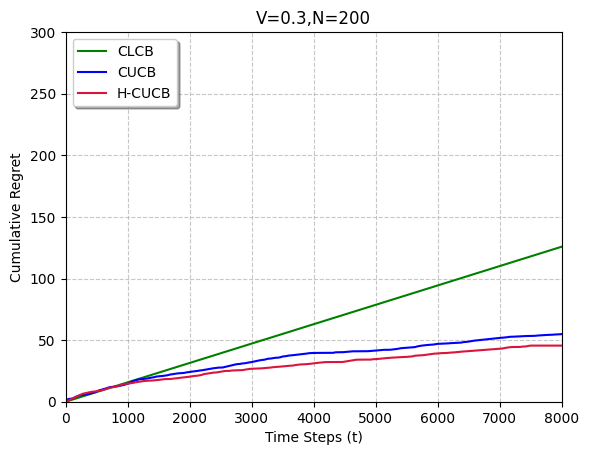

In [90]:
clear_variables()
print("Clear up")
m = 10
k = 5
num_trials = 5
bias = 0.3
mu_on = np.linspace(0.3,0.5,m)
# mu_on = np.random.uniform(0.3,0.7,m) # Adjust : 0 can be changed to 0.5,0.6
# mu_on[0] = 0.699

print(f"mu_on:{mu_on}")


# bias generation
while True:
    V = [bias] * m # Bias bound
    count = 0
    for i in range(m):
        if random.random() < 0.5:
            V[i] = -V[i]
            count += 1
    if m / 2 - 5 <= count <= m / 2 + 5:
        break


# V = [bias] * m # Bias bound
# for i in range(m):
#     if random.random() < 0.5:
#         V[i] = -V[i]


mu_off =  mu_on + V 

V1 = [bias] * m

# 2.Find the oracle 
super_arm_oracle = oracle_select(mu_on,k)
print(f"super_arm_oracle:{super_arm_oracle}")
reward_star = expect_reward(mu_on,super_arm_oracle)
print(f"reward_star:{reward_star}")


# 3. do offline, online, hybrid-unbiased, hybrid-biased
## 3.1 offline
reward_off = 0
reward = []
num_each_arm = 200
reward_off,N_off,mu_hat_off = RewardOff(m,mu_off,k,mu_on,num_each_arm,off_turn= 1)# 5000 is not good, maybe it's because of the seed
print(f"reward_off:{reward_off}")

print()
print(f"gap_off:{reward_star - reward_off }")


T = int(input("T:"))

print(f"T = {T}")
gap_offline = (reward_star - reward_off ) * range(1,T+1)
gap_online = np.zeros(T)
gap_hybrid_biased = np.zeros(T)
gap_on = []
gap_hb = []

# 3.2 online, hybrid-unbiased, hybrid-biased

# Run the simulation 5 times

gap_online, gap_hybrid_biased = single_run_hybrid(m, k, T, reward_star, mu_on,gap_offline, N_off, mu_hat_off, V1)


# 4.Plot
plt.plot(gap_offline, color='green', label='CLCB')
plt.plot(gap_online, color='blue', label='CUCB')
plt.plot(gap_hybrid_biased, color='crimson', label='H-CUCB')

plt.xlim(0,T)
plt.ylim(0,300)
plt.xlabel("Time Steps (t)")
plt.ylabel("Cumulative Regret")
plt.title(f"V={bias},N={num_each_arm}")

# Customize the legend location and appearance
plt.legend(loc='upper left', frameon=True, shadow=True)

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()